In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import re
from konlpy.tag import Okt
from gensim.models import Word2Vec
import fasttext
from huggingface_hub import hf_hub_download
import seaborn as sns

/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [3]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

모든 장르에 대해 영화 구분과의 편향성 정도를 측정.
# STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [4]:
with open(os.getenv('HOME')+'/work_space/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [5]:
# from konlpy.tag import Okt
# okt = Okt()
# tokenized = []
# with open(os.getenv('HOME')+'/work_space/aiffel/weat/synopsis.txt', 'r') as file:
#     while True:
#         line = file.readline()
#         if not line: break
#         words = okt.pos(line, stem=True, norm=True)
#         res = []
#         for w in words:
#             if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
#                 res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
#         tokenized.append(res)

In [6]:
# # tokenized join한 후 파일로 저장
# tokenized_filename = 'tokenized.txt'
# with open(tokenized_filename, 'w', encoding='utf-8') as f:
#     for tokens in tokenized:
#         line = ' '.join(tokens) + '\n'
#         f.write(line)

# STEP 2. 추출된 결과로 embedding model 만들기

In [7]:
# model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

# 모델 저장
# model.save('word2vec.model')

In [8]:
# 모델 로드
model = Word2Vec.load('word2vec.model')

In [9]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.8902981281280518),
 ('다큐멘터리', 0.8464424014091492),
 ('드라마', 0.8160082697868347),
 ('영화로', 0.8152096271514893),
 ('형식', 0.7856435775756836),
 ('코미디', 0.7817586660385132),
 ('주제', 0.7809075713157654),
 ('소설', 0.7661939859390259),
 ('소재', 0.7630091905593872),
 ('영상', 0.7604784965515137)]

In [10]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.7063462734222412),
 ('첫사랑', 0.6987630128860474),
 ('진심', 0.6970039010047913),
 ('가슴', 0.6903089284896851),
 ('애정', 0.6817137002944946),
 ('토마슈', 0.6767436265945435),
 ('만남', 0.6645476222038269),
 ('고백', 0.6636297702789307),
 ('열정', 0.6634331941604614),
 ('운명', 0.662251889705658)]

In [11]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.9026100039482117),
 ('영화감독', 0.8792871832847595),
 ('캐스팅', 0.8741727471351624),
 ('배우', 0.8711680769920349),
 ('데뷔', 0.8686666488647461),
 ('연기자', 0.868060290813446),
 ('대본', 0.8677303194999695),
 ('오페라', 0.8664679527282715),
 ('영감', 0.8601993322372437),
 ('아티스트', 0.8584378361701965)]

# STEP 3. target, attribute 단어 셋 만들기
TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생.  
TF-IDF를 적용했을 때의 문제점이 무엇인지 지적, 스스로 방법을 개선하여 대표 단어 셋 구축.

In [12]:
movie_categories = ['art', 'gen']
genre_categories = ['action', 'adult', 'adventure', 'animation', 'comedy', 'crime',
                    'documentary', 'drama', 'etc', 'family', 'fantasy', 'historical',
                    'horror', 'musical', 'romance', 'SF', 'show', 'thriller', 'war',
                    'western']

In [13]:
data_dir = os.getenv('HOME')+'/work_space/aiffel/weat/data'
data_files = os.listdir(data_dir)

movie_files = []
genre_files = []

pattern = re.compile(r'_(.*?)\.')
for file in data_files:
    match = pattern.search(file)
    
    if match == None:
        continue

    category = match.group(1)
    if category in movie_categories:
        movie_files.append(file)
    elif category in genre_categories:
        genre_files.append(file)

print(movie_files)
print(genre_files)

['synopsis_gen.txt', 'synopsis_art.txt']
['synopsis_war.txt', 'synopsis_romance.txt', 'synopsis_horror.txt', 'synopsis_animation.txt', 'synopsis_adventure.txt', 'synopsis_documentary.txt', 'synopsis_historical.txt', 'synopsis_show.txt', 'synopsis_drama.txt', 'synopsis_etc.txt', 'synopsis_adult.txt', 'synopsis_western.txt', 'synopsis_comedy.txt', 'synopsis_family.txt', 'synopsis_thriller.txt', 'synopsis_fantasy.txt', 'synopsis_crime.txt', 'synopsis_musical.txt', 'synopsis_SF.txt', 'synopsis_action.txt']


## FastText을 이용한 유사 단어셋 생성
TF-IDF는 고빈도 단어가 높게 평가됨.
- 단어의 빈도(TF): 단어가 특정 문서에서 자주 등장할 수로 TF값이 높아짐.  
- 역문서 빈도(IDF): IDF는 전체 문서 집합에서 단어의 일반적인 중요성을 측정. 단어가 전체 문서 집합에서 자주 

등장할수록 IDF값은 낮아짐. 많은 문서에서 등장하는 단어는 IDF값이 낮아지지 않을 수 있음.  
Word2Vec은 OOV문제로 사용하지 않음.
따라서 단어 임베딩 기법인 FastText을 사용하여 영화 구분, 장르와 유사한 단어셋을 생성함.
FastText는 한국어를 기반으로 학습된 pre-trained model인 facebook/fasttext-ko-vectors 사용.
[facebook/fasttext-ko-vectors](https://huggingface.co/facebook/fasttext-ko-vectors)

In [14]:
model_path = hf_hub_download(repo_id="facebook/fasttext-ko-vectors",
                             filename="model.bin")
fasttext_model = fasttext.load_model(model_path)

In [15]:
fasttext_model.get_nearest_neighbors('예술영화', k = 20)

[(0.7107282280921936, '예술영화관'),
 (0.6688271760940552, '예술영화를'),
 (0.6556655764579773, '예술영화와'),
 (0.6189515590667725, '산업영화와'),
 (0.6092895269393921, '예술영화의'),
 (0.5928533673286438, '예술영화에'),
 (0.5865684151649475, '예술영화가'),
 (0.5292477011680603, '독립영화와'),
 (0.5236456990242004, '상업영화와'),
 (0.5158618092536926, '생태론적'),
 (0.5130625367164612, '1.영화란'),
 (0.5112410187721252, '가족영화'),
 (0.5072950720787048, '독립영화는'),
 (0.5024582147598267, '다부작'),
 (0.5005242228507996, '상업영화를'),
 (0.48606833815574646, '시집와요'),
 (0.48515215516090393, '작가영화'),
 (0.4849347472190857, '영화산업과'),
 (0.4849212169647217, '북한영화'),
 (0.4829888939857483, '상업영화의')]

조사가 모두 포함된 문제가 있음. 모델에서 명사만 뽑아내는 기능은 없으므로 synopsis.txt에서 명사만 추출한 tokenized를 input으로 FastText 모델 학습시켜 사용함.

In [16]:
# # FastText 모델 학습
# festtext_model = fasttext.train_unsupervised(
#     input='tokenized.txt',
#     model='skipgram',
#     dim=100,
#     minCount=5,
#     epoch=10
# )

# fasttext_model.save_model('fasttext_model.bin')

In [17]:
fasttext_model = fasttext.load_model('fasttext_model.bin')

fasttext_model.get_nearest_neighbors('예술영화', k = 20)

[(0.8460202217102051, '예술제'),
 (0.8170338273048401, '미국영화'),
 (0.816444456577301, '작품'),
 (0.8119781017303467, '픽처스'),
 (0.8008912205696106, '영화'),
 (0.7966316938400269, '평단'),
 (0.7941138744354248, '프롤로그'),
 (0.7883279323577881, '중국영화'),
 (0.785078763961792, '상반기'),
 (0.7841079831123352, '촬영상'),
 (0.7823179364204407, '오타와'),
 (0.7801780104637146, '이상용'),
 (0.7796684503555298, '극영화'),
 (0.7747688889503479, '시대극'),
 (0.7747217416763306, '데카당스'),
 (0.7738476991653442, '실험영화'),
 (0.7732484936714172, '프린팅'),
 (0.7728821039199829, '스토리텔링'),
 (0.7723907828330994, '이수원'),
 (0.7720354795455933, '뒷이야기')]

In [18]:
def get_similar_words(model, word, k=20):
    similar_words = model.get_nearest_neighbors(word, k=k)
    words_only = [word[1] for word in similar_words]
    return words_only

In [19]:
categories = {
    '예술영화': 'art', '상업영화': 'gen', '액션': 'action', '성인물': 'adult',
    '어드벤처': 'adventure', '애니메이션': 'animation', '코미디': 'comedy', '범죄': 'crime',
    '다큐멘터리': 'documentary', '드라마': 'drama', '기타': 'etc', '패밀리': 'family',
    '판타지': 'fantasy', '사극': 'historical', '공포': 'horror', '뮤지컬': 'musical',
    '멜로로맨스': 'romance', 'SF': 'SF', '공연': 'show', '스릴러': 'thriller', '전쟁': 'war',
    '서부극': 'western'
}

In [20]:
attributes = []
for category_ko, category_en in categories.items():
    if category_ko == '예술영화' or category_ko == '상업영화':
        globals()['target_{}'.format(category_en)] = get_similar_words(
            fasttext_model, category_ko, k = 10
        )
        print(
            '{}:'.format(category_en),
            globals()['target_{}'.format(category_en)]
        )
    else:
        attributes.append('attribute_{}'.format(category_en))
        globals()['attribute_{}'.format(category_en)] = get_similar_words(
            fasttext_model, category_ko, k = 10
        )
        print(
            '{}:'.format(category_en),
            globals()['attribute_{}'.format(category_en)]
        )

art: ['예술제', '미국영화', '작품', '픽처스', '영화', '평단', '프롤로그', '중국영화', '상반기', '촬영상']
gen: ['픽처스', '중국영화', '미국영화', '영화', '상업성', '작품', '경향', '액션영화', '이수원', '시대극']
action: ['액션영화', '액션스쿨', '블록버스터', '하드코어', '매트릭스', '끝판', '어드벤쳐', '스릴러물', '짜임새', '논스톱']
adult: ['성인식', '플러그', '통과의례', '장시간', '그라비아', '성인', '승환', '에세', '옌', '자신']
adventure: ['어드벤쳐', '스타워즈', '디즈니', '스머', '마다가스카', '스머프', '모험', '천외', '인어공주', '서사시']
animation: ['애니메이션상', '오타와', '페스티벌', '애니매이션', '뉴미디어', '시체스', '안시', '판토체', '바덴', '애니마드리드']
comedy: ['슬랩', '스틱', '블랙코미디', '블록버스터', '유머', '비약', '블랙유머', '코믹', '폭소', '호러']
crime: ['범죄수사', '조직', '범죄자', '로드리게즈', '연루', '마약단속국', '법망', '장가휘', '감찰', '킹핀']
documentary: ['멘타리', '다큐', '미국영화', '모큐멘터리', '화이자', '연작', '풀턴', '이수원', '이란인', '진실성']
drama: ['멜로드라마', '호청', '휴먼', '슬랩', '극영화', '이상용', '이수원', '고품격', '액션영화', '미니시리즈']
etc: ['기타리스트', '음악감독', '홍대', '스윙', '드러머', '밴드', '버스킹', '헤드폰', '포크송', '드럼']
family: ['버스터', '천외', '감언이설', '샤샤', '라이어', '펫', '논스톱', '밀턴', '클리어', '개구쟁이']
fantasy: ['판타지아', '전래', '가족영화', '서스펜스', '블랙유

중복되는 단어가 보이기도 하지만 중복되는 단어가 많아서 쓰지 못할 정도는 아닌 걸로 보임. 해당 단어셋을 사용해도 될 것같음.
# STEP 4. embedding model과 단어 셋으로 WEAT score 구해보기

In [21]:
matrix = [[0 for _ in range(len(genre_categories))] for _ in range(len(genre_categories))]

In [22]:
print([model.wv[word] for word in globals()[attributes[i]]])

[array([-0.05375076,  0.23461874,  0.40764284,  0.39773953, -0.33145115,
       -0.5132747 , -0.00134377,  0.8867986 , -0.06348142, -0.3629588 ,
       -0.10362747, -0.43641046,  0.17922151, -0.10403065, -0.23761928,
       -0.36418217, -0.1167746 , -0.01242606, -0.01289252, -0.57988566,
        0.10482763,  0.11080067,  0.4210713 , -0.42408496, -0.36541313,
        0.5318906 , -0.44233993, -0.10793975, -0.26449975,  0.44284528,
        0.4169877 ,  0.41554013, -0.06657524,  0.02396473, -0.3525477 ,
       -0.15208665, -0.1875802 , -0.19979216, -0.51497155, -0.17452733,
        0.25401258, -0.17833492, -0.24528207, -0.49310875,  0.05113344,
       -0.35210934, -0.16642499, -0.06391262, -0.16115798, -0.05028707,
        0.0963499 , -0.16659807, -0.29088935, -0.23474066, -0.08140929,
       -0.09680691,  0.02441987, -0.00243086, -0.33873978,  0.14729516,
       -0.20153497, -0.3340134 ,  0.22008075,  0.44350585, -0.2329032 ,
        0.58707553, -0.32422635,  0.03072168, -0.57704884,  0.2

In [23]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_categories)-1):
    for j in range(i+1, len(genre_categories)):
        A = np.array([model.wv[word] for word in globals()[attributes[i]]])
        B = np.array([model.wv[word] for word in globals()[attributes[j]]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [24]:
bias_words_set = []
for i in range(len(genre_categories)-1):
    for j in range(i+1, len(genre_categories)):
        print(genre_categories[i], genre_categories[j], matrix[i][j])
        if abs(matrix[i][j]) > 0.8:
            bias_words_set.append(genre_categories[i], genre_categories[j], matrix[i][j])

action adult -0.019561447
action adventure -0.023810966
action animation -0.03846836
action comedy -0.012474032
action crime -0.020251945
action documentary -0.06408902
action drama -0.025453622
action etc -0.029773405
action family -0.0005717377
action fantasy -0.19722284
action historical -0.13555169
action horror -0.0090046
action musical -0.10120503
action romance -0.034120858
action SF -0.013439885
action show -0.056106184
action thriller -0.07474163
action war 0.0009809118
action western -0.025850909
adult adventure 0.0104340715
adult animation -0.02285292
adult comedy 0.012322301
adult crime -0.022328183
adult documentary 0.003802216
adult drama 0.0098689655
adult etc 0.0071569793
adult family 0.075423874
adult fantasy -0.00045626826
adult historical -0.0019638208
adult horror 0.029884273
adult musical 0.012588017
adult romance 0.015509566
adult SF 0.06234674
adult show 0.0086861355
adult thriller 0.009471175
adult war 0.04433962
adult western 0.011982572
adventure animation -0.

In [25]:
print(bias_words_set)

[]


절댓값이 0.8이 넘는 단어셋은 보이지 않음. FastText를 이용해서 단어 셋을 만들고 WEAT score를 계산하면 편향성을 보이는 genre는 없어 보임.  
가장 높은 편향성을 보이는 genre는 war와 western으로 WEAT score가 약 -0.57을 보임. 부호가 마이너스이므로 사람의 편향과는 반대임.

<Axes: >

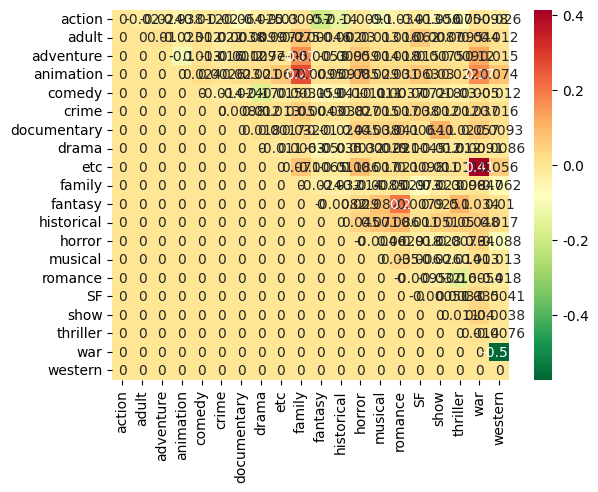

In [26]:
np.random.seed(0)

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_categories, yticklabels=genre_categories, annot=True,  cmap='RdYlGn_r', annot_kws={'size': 10})
ax